In [2]:
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import imageio
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import cv2
from matplotlib.colors import hsv_to_rgb
import geojson
from pyproj import Proj
UTM_10_PROJ = Proj("+proj=utm +zone=10N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")


(10000, 10000, 3) uint8


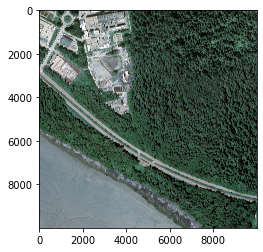

In [3]:
os.chdir(os.path.join(et.io.HOME, "ubc/capstone/orthophoto/2014"))
image = cv2.imread('483E_5454N.tif')
type(image)
print(image.shape, image.dtype)
plt.imshow(image)
nemo = image[:5000, :5000, :]
hsv_nemo = cv2.cvtColor(nemo[:5000,:5000,:], cv2.COLOR_RGB2HSV)

In [ ]:
nemo = image[:5000, :5000, :]
r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()


NameError: name 'pixel_colors' is not defined

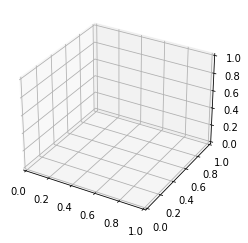

In [37]:
hsv_nemo = cv2.cvtColor(nemo[:5000,:5000,:], cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker="x")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()


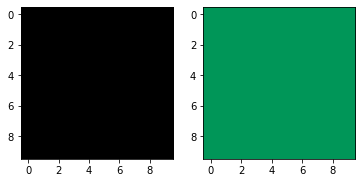

In [3]:
dark_green = (50,0, 0)
light_green = (110, 255, 150)
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

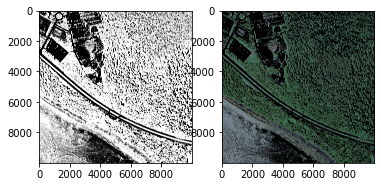

0:00:05.442942


In [4]:
startTime = datetime.now()
nemo = image
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_nemo, dark_green, light_green)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()
print(datetime.now() - startTime)

In [5]:
def blur_image_plot(image, n):
    fig, ax = plt.subplots(1, n+1, figsize=(10, 10), sharex=True, sharey=True)
    print("std dev\n=======\noriginal: {}".format(image.std()))
    ax[0].imshow(image)
    for i in range(1,n+1):
        blurred_image = ndimage.gaussian_filter(image, sigma=2*i)
        print("blurred, sigma = {}: {}".format(2*i, blurred_image.std()))
        ax[i].imshow(blurred_image)
blur_image_plot(nemo,4)

std dev
original: 57.35351437448707
blurred, sigma = 2: 52.826524445702105
blurred, sigma = 4: 51.33009473092638


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f69083377b8> (for post_execute):


KeyboardInterrupt: 

In [ ]:
def plot_window_stddev(n, window_size, offset,im):
    fig, ax = plt.subplots(n, n, figsize=(20,20), sharex=True, sharey=True)

    for y in range(offset,n+offset):
        for x in range(offset,n+offset):
            r = im[y*window_size:(y+1)*window_size, x*window_size:(x+1)*window_size, 0:3]
            ax[y-offset,x-offset].imshow(r)
            ax[y-offset,x-offset].set_title("{:.2f}".format(r.std()))
plot_window_stddev(10,10,0,nemo)

In [ ]:
blurred_image = ndimage.gaussian_filter(nemo, sigma=2)
plot_window_stddev(10,20,200,blurred_image)

In [1]:
blurred_image = ndimage.gaussian_filter(nemo, sigma=2)
plt.imshow(blurred_image, cmap=plt.cm.gray)

NameError: name 'ndimage' is not defined

In [7]:
def stddev_above_threshold(x,y,window_size, threshold,im):
    r = im[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size, 0:3]
    return r.std() > threshold

0:00:07.118175


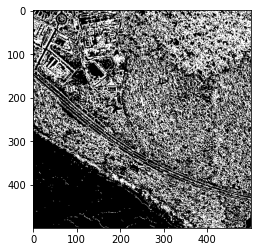

In [8]:
n = 500
startTime = datetime.now()
stddev_array = np.array([stddev_above_threshold(i//n,i%n,20,15,blurred_image) for i in range(0,n**2)]).reshape(n,n)
print(datetime.now() - startTime)
plt.imshow(stddev_array, cmap=plt.cm.gray)

0:00:10.200676


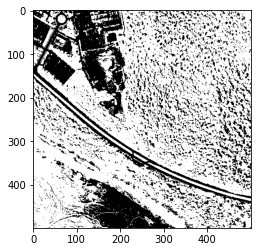

In [9]:
def compressed_green(x,y,window_size,green_mask):
    r = green_mask[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size]
    return r.mean() > 128
n = 500
compressed_green_array = np.array([compressed_green(i//n,i%n,20,mask) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(compressed_green_array, cmap=plt.cm.gray)
print(datetime.now() - startTime)

In [10]:
print(compressed_green_array)

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True False]
 [ True  True  True ... False False False]]


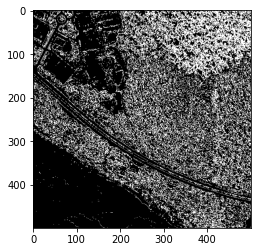

In [11]:
n=500
green_stddev_array = np.array([compressed_green_array[i//n,i%n] and stddev_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
plt.imsave("green_stddev.png", green_stddev_array)
plt.imshow(green_stddev_array,cmap=plt.cm.gray)

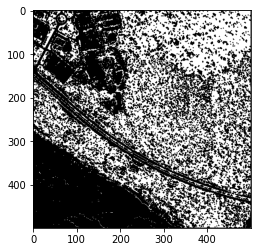

In [12]:
close_img = ndimage.binary_closing(green_stddev_array)
plt.imshow(close_img, cmap=plt.cm.gray)

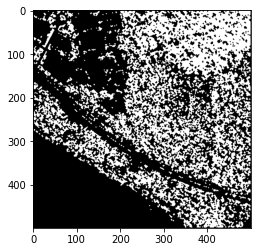

In [13]:
open_img = ndimage.binary_opening(close_img)
plt.imshow(open_img, cmap=plt.cm.gray)
plt.imsave("green_stddev.png", open_img)


In [14]:
im = cv2.imread('green_stddev.png')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)

In [15]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [16]:
im = cv2.imread('green_stddev.png')
img = cv2.drawContours(im, contours, 1000, (0,255,0), 3)
plt.imshow(img)

error: OpenCV(4.5.1) /tmp/pip-req-build-1syr35c1/opencv/modules/imgproc/src/drawing.cpp:2490: error: (-215:Assertion failed) 0 <= contourIdx && contourIdx < (int)last in function 'drawContours'


In [148]:
contours[1000]

array([[[336,  41]],

       [[339,  44]],

       [[336,  47]],

       [[335,  47]],

       [[333,  45]],

       [[334,  44]],

       [[334,  43]]], dtype=int32)

In [17]:
len(contours   )

375

In [18]:
def convert_to_lon_lat(polygon_10_m, utm_10_bot_left_coord):
    polygon_10_m = polygon_10_m/ 10
    polygon_10_m = [[x[0][0]+utm_10_bot_left_coord[0],1000-x[0][1]+utm_10_bot_left_coord[1]] for x in polygon_10_m]
    projected = [UTM_10_PROJ(x[0], x[1], inverse=True) for x in polygon_10_m]
    head = projected[0]
    projected.append(head)
    return projected
lon_lat = convert_to_lon_lat(contours[0]*20,[483000,5454000])
lon_lat

[(-123.22142413237158, 49.23863641255583),
 (-123.22145152710686, 49.238618369540404),
 (-123.22142397152196, 49.23860043185357),
 (-123.22139649637171, 49.238600484511316),
 (-123.22136910162621, 49.23861852751376),
 (-123.2213966572014, 49.238636465213645),
 (-123.22142413237158, 49.23863641255583)]

In [19]:
feature_list = []
for c in contours:
    lon_lat = convert_to_lon_lat(c*20,[483000,5454000])
    feature_list.append(geojson.Feature(geometry=geojson.Polygon([lon_lat])))
feature_collection = geojson.FeatureCollection(feature_list)

with open("polygons.geojson", mode = "w") as out_file:
    geojson.dump(feature_collection,out_file)
